## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Part 1: Compute the camera calibration using chessboard images
Camera calibration is the first step to do. Camera calibration will produce camera matrix value and also distortion coefficient that will be used to undistort images. Due to various reason i.e camera lens the produced images most likely will be distorted. In order to proceed with lane finding we need to undistort the distorted images, thus we need to calibrate the camera. 

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#import PyQt5
#%matplotlib qt

# Prepare object points, like (x, y, z): 
# [(0,0,0), 
# (1,0,0), 
# (2,0,0),
# ....,
# (8,5,0)]
# Object points will hold pixel information in 3D world space for each detected
# chessboard corner. However, since the chessboard image taken on flat surface then
# the 'z' point will be always zero.
objp = np.zeros((6*9,3), np.float32) # The calibrated image sample are 9x6
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow(fname,img)
        cv2.waitKey(500)
        
    cv2.destroyAllWindows()
    cv2.waitKey(1)

Apply camera calibration on test image using object points and image points taken from calibration images above.

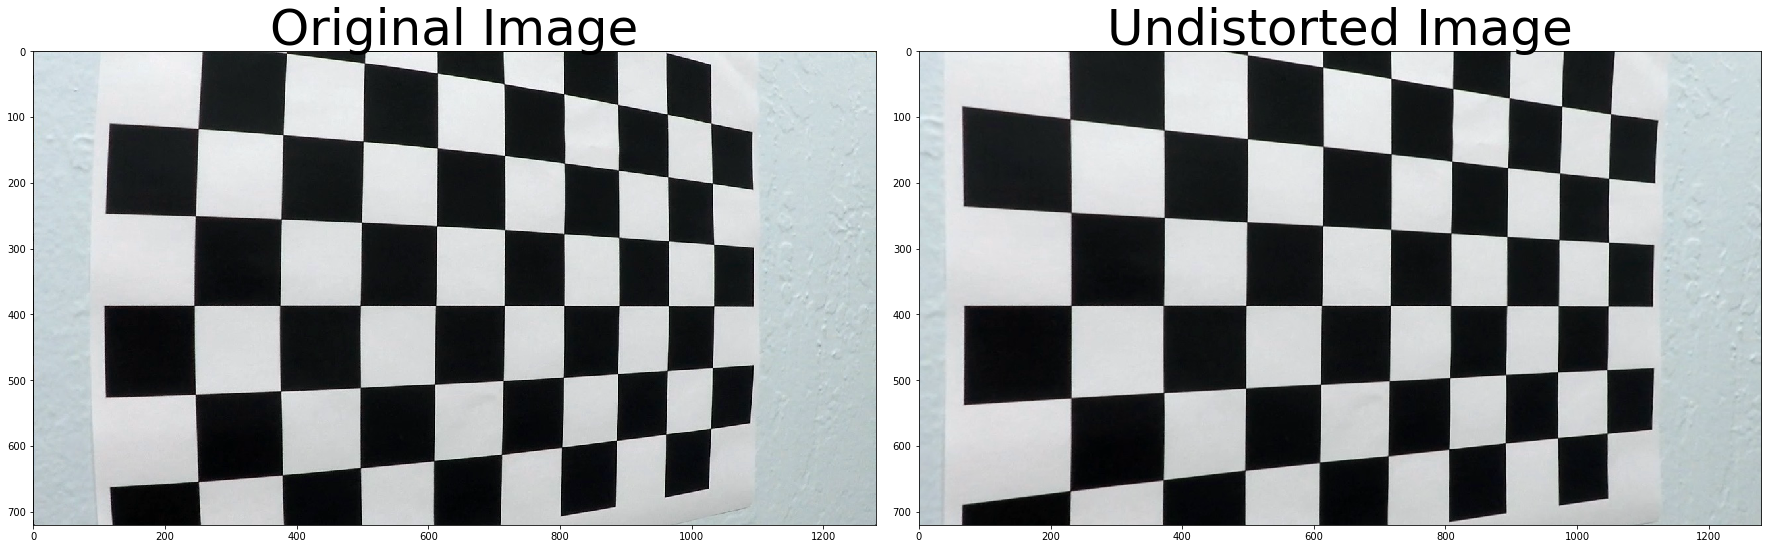

In [5]:
%matplotlib inline

img = cv2.imread('camera_cal/test_image5.jpg')
img_size = (img.shape[1], img.shape[0])

# Perform camera calibration to get camera matrix, calibration coeficients, rotation, and translation vectors.
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Undistort test image
undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)

# Draw original image, and undistort image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Save camera matrix and distortion coefficient into pickled file so we can use it later to perform image undistortion without doing camera calibration again.

In [7]:
import pickle

camera_calibration = {}
camera_calibration["mtx"] = mtx
camera_calibration["dist"] = dist
pickle.dump( camera_calibration, open( "camera_calibration.p", "wb" ) )

## Parth 2: Extract lane line from images
The images produced by camera will be containing various objects such as trees, cars, traffic signs, etc. We need to extract lane lines only from the images. The lane lines itself can be in various conditions such as white color, yellow color, under bright light, low light, within shadow coming from trees, etc. Due to various conditions of lane lines then I need a proven technique to extract lane lines part that separate it from other objects. 

### Thresholding
Thresholding is used to segment an image by setting all pixels whose intensity values are above a threshold to a foreground value and all the remaining pixels to a background value. Thresholding typically takes a grayscale or color image as input and, in the simplest implementation, outputs a binary image representing the segmentation. Binary image are images whose pixels have only two possible intensity values. They are normally displayed as black and white. Numerically, the two values are often 0 for black, and either 1 or 255 for white.

For this project, I will be using two type of thresholding: **Gradient Thresholding** and **Color Thresholding**.

---

** Gradient Thresholding **

Different lighting or camera properties can cause two images of the same scene to have drastically different pixel values. This can cause matching algorithms to fail to match very similar or identical features. One way to solve this is to compute texture or feature signatures based on gradient images computed from the original images. These gradients are less susceptible to lighting and camera changes, so matching errors are reduced.

In this case, gradient will be used to find lane lines. 

These are algorithm / function related to gradient thresholding:

In [2]:
import numpy as np

# Calculate directional gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    #    is > thresh_min and < thresh_max, that is saying if pixel value
    #    between threshold minimum and threhsold maximum, set the binary
    #    output as '1' (white dot), otherwise the output will be zero (black dot)
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return the mask as binary image
    return binary

# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude of both sobel's direction
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale the gradient magnitude to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradient_magnitude)/255 
    gradient_magnitude = (gradient_magnitude/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where magnitude thresholds are met
    binary = np.zeros_like(gradient_magnitude)
    binary[(gradient_magnitude >= thresh[0]) & (gradient_magnitude <= thresh[1])] = 1
    
    # 6) Return the mask as binary image
    return binary

# Calculate gradient direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary = np.zeros_like(abs_grad_direction)
    binary[(abs_grad_direction >= thresh[0]) & (abs_grad_direction <= thresh[1])] = 1
    # 6) Return this mask as your binary image
    return binary

Here are the sample of using gradient threshold on test images. I perform several experiment to see how gradient thresholding applied on test images and how to use it to extract lane lines from the images.

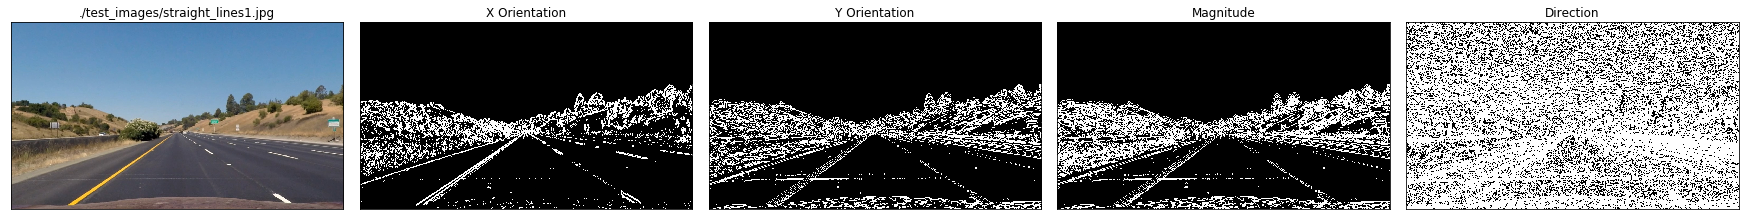

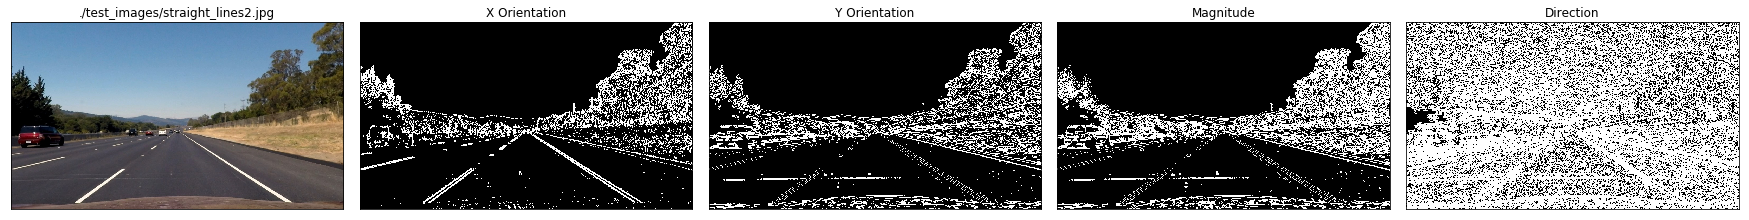

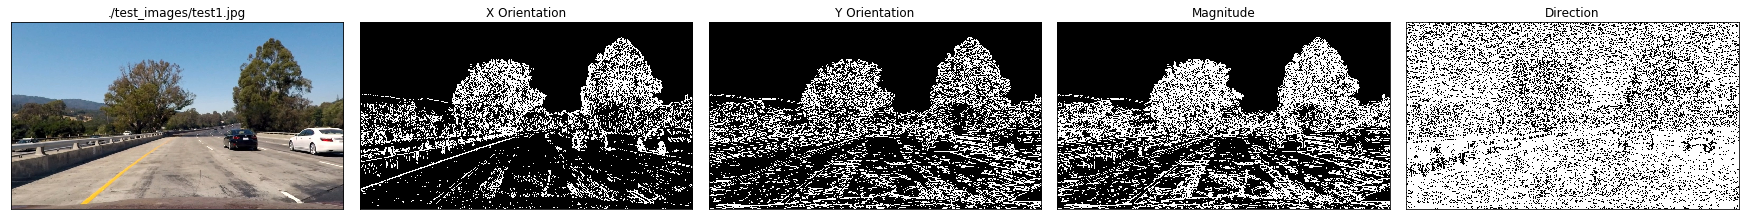

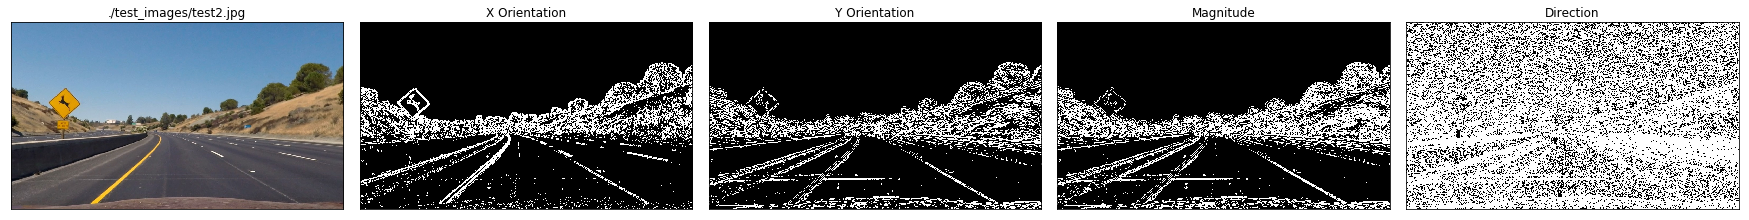

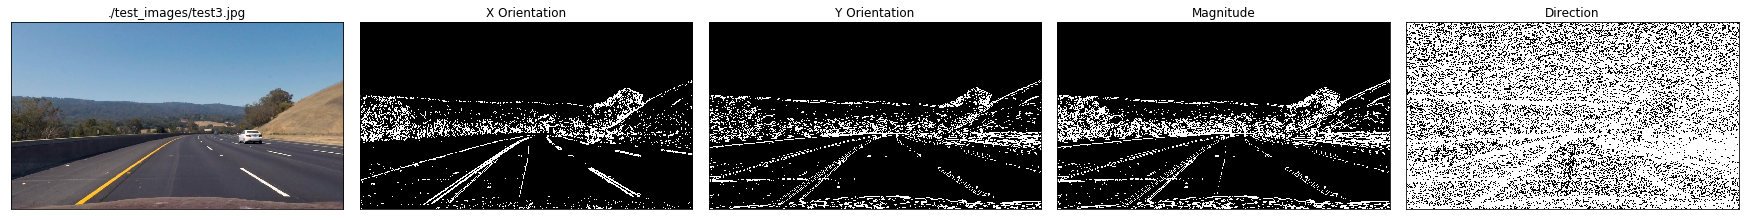

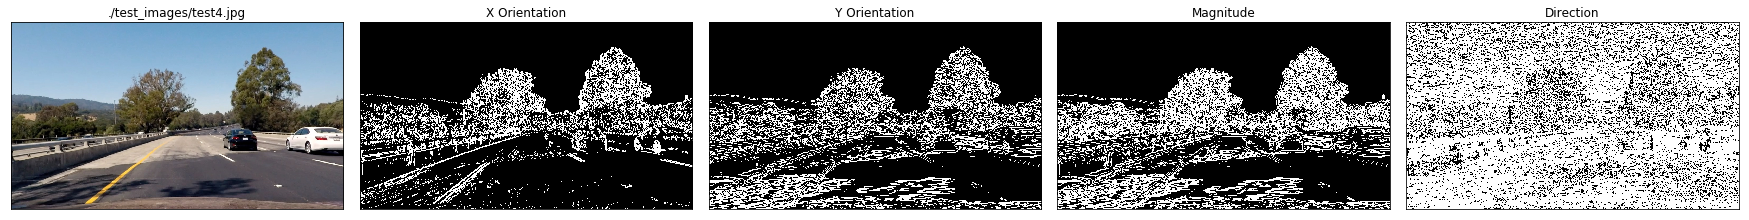

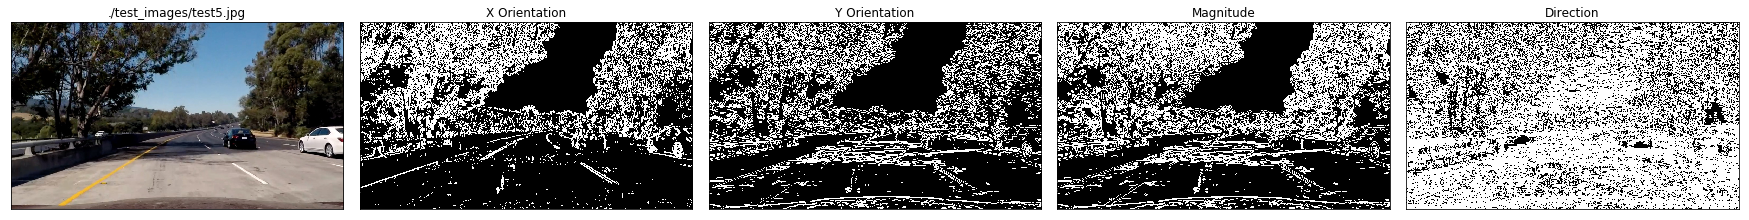

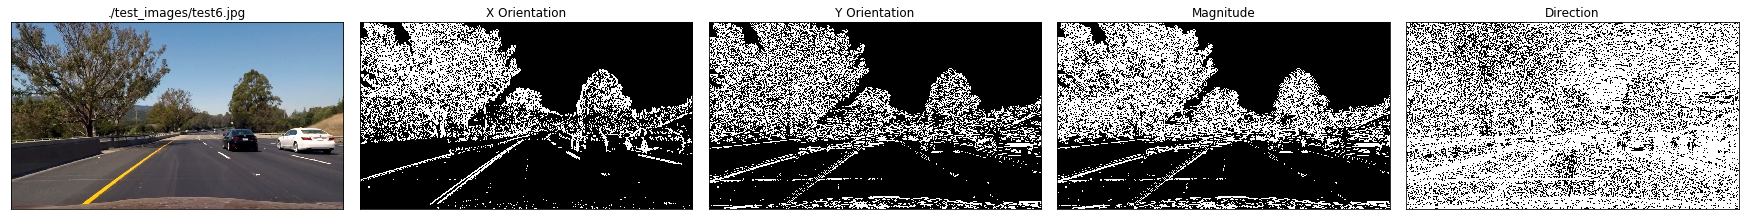

In [3]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read camera calibration matrix and distortion coefficient from pickled file
camera_calibration = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = camera_calibration["mtx"]
dist = camera_calibration["dist"]

# Read all test images file
test_images = glob.glob('./test_images/*.jpg')

# Title information for displayed result
images_title = ["Source Image", "X Orientation", "Y Orientation", "Magnitude", "Direction"]

# # Choose a larger odd number kernel size to smooth gradient measurements
ksize = 7

# Perform color channeled on test images to see which channel best to use
for fname in test_images:
    # Read the image
    image = mpimg.imread(fname)
    
    # Undistort test image
    image = cv2.undistort(image, mtx, dist, None, mtx)

    # apply gradient threshold on the horizontal
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 200))
    # apply gradient threshold on the vertical
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(10, 50))
    # apply gradient threshold on the horizontal & vertical
    mag_b = mag_thresh(image, sobel_kernel=ksize, thresh=(10, 50))
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_b = dir_threshold(image, sobel_kernel=ksize, thresh=(np.pi/6, np.pi/2))

    # Apply combined gradient threshold
    #combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_b == 1) & (dir_b == 1))] = 1

    images = [image, gradx, grady, mag_b, dir_b]
    
    # Plot the result
    fig = plt.figure(figsize = (24, 9))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    # Display result of color channeled image for each test images
    for i in range(5):
        axis = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        if i == 0:
            axis.set_title(fname)
        else:
            axis.set_title(images_title[i])
        axis.imshow(images[i], cmap='gray')
    
    plt.show()



It seems with gradient threshold the most difficult image to detect lane lines are whenever the lines color is yellow and the road color is light gray (bright, not dark), thus the test images are **test1.jpg and test5.jpg**. Image **test4.jpg** also interesting since it cover dark and also bright road. This issue will be handled through color thresholding.

Meanwhile, based on experiments I will combine absolute gradient threshold with orientation horizontal (x) and vertical (y) to extract lane line. Here's the test of combined gradient thresholding.

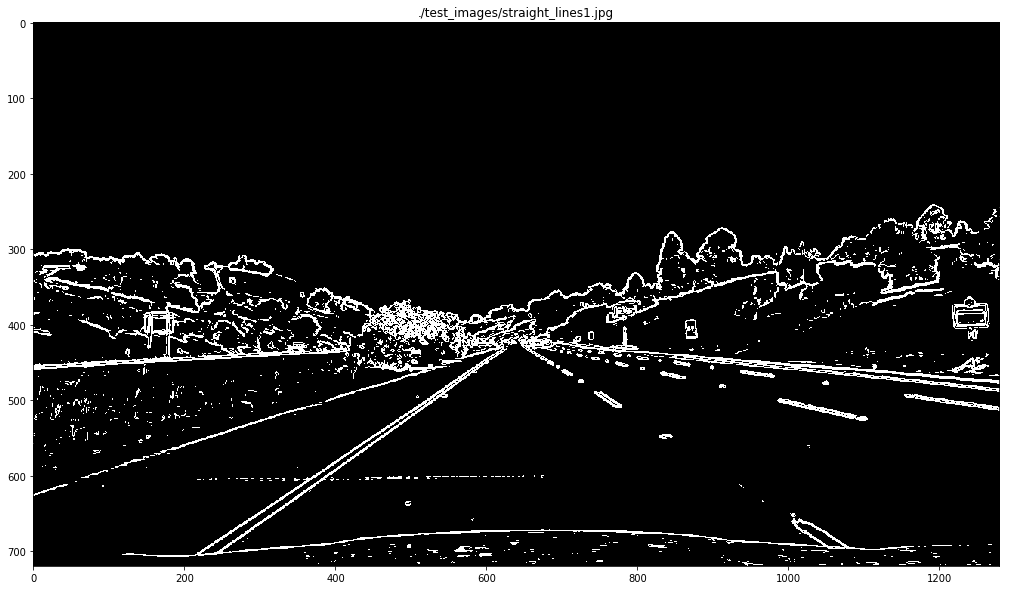

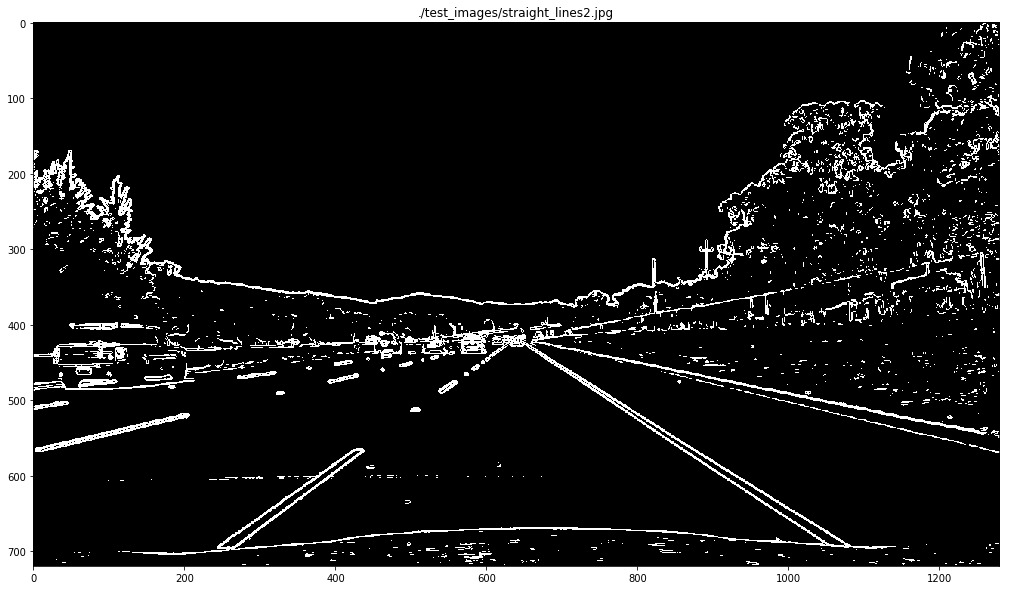

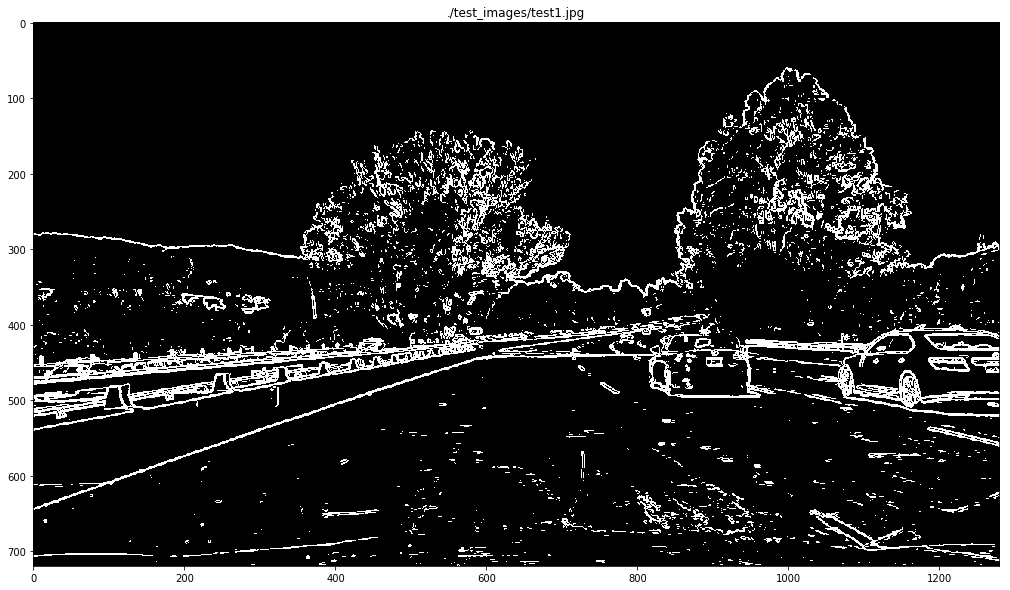

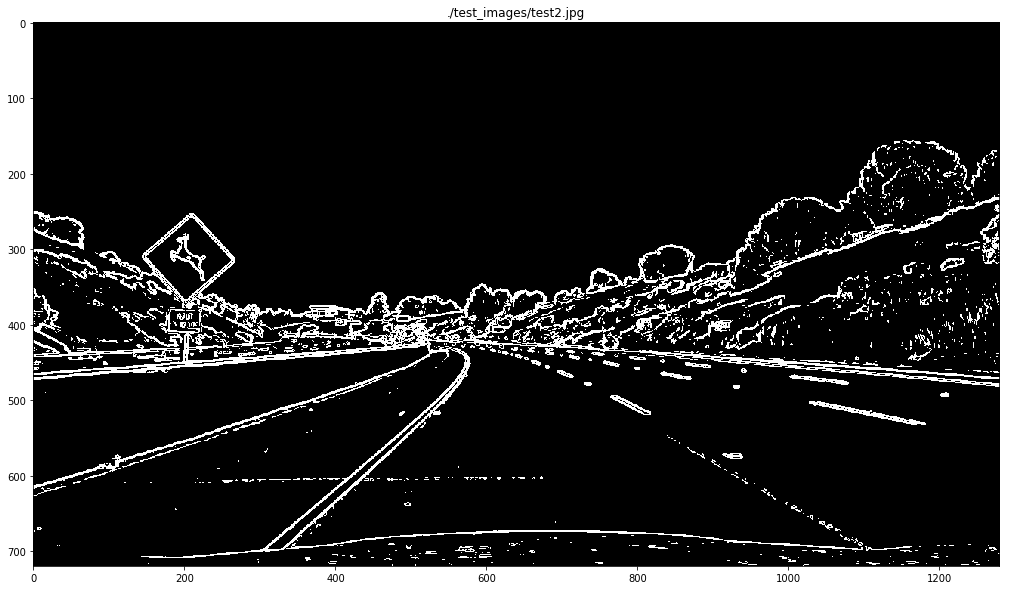

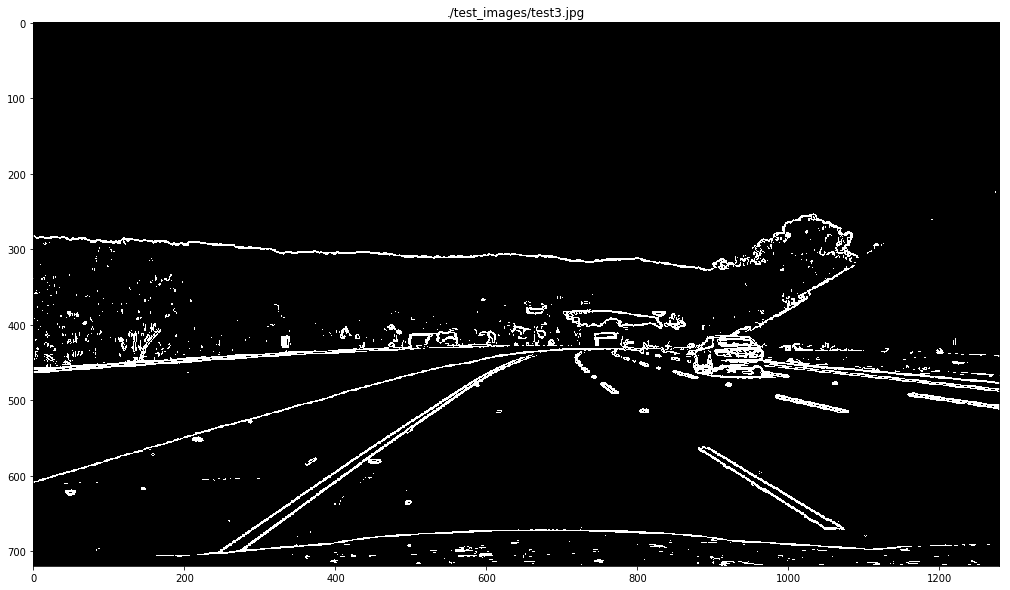

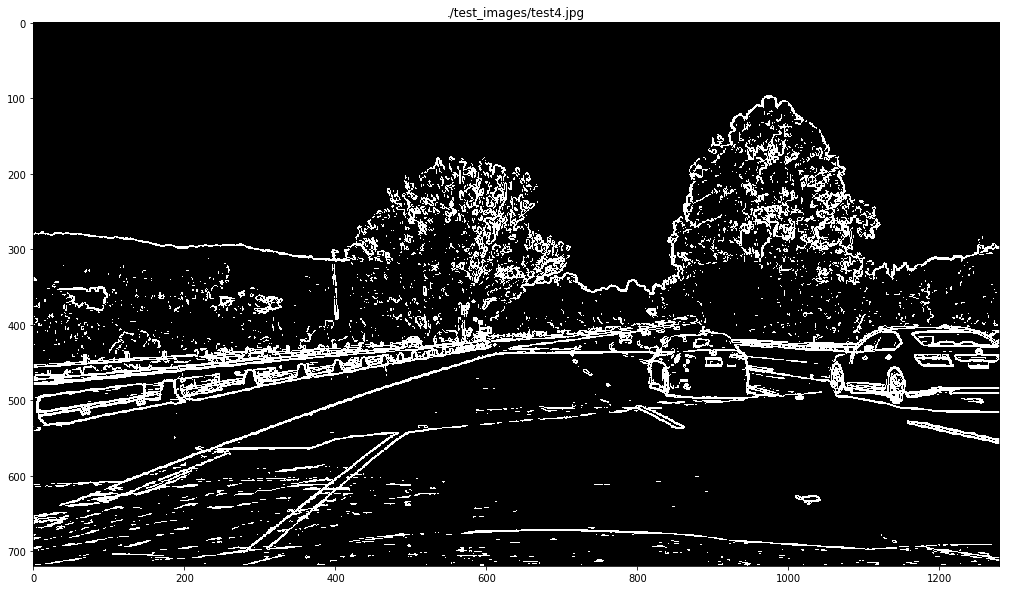

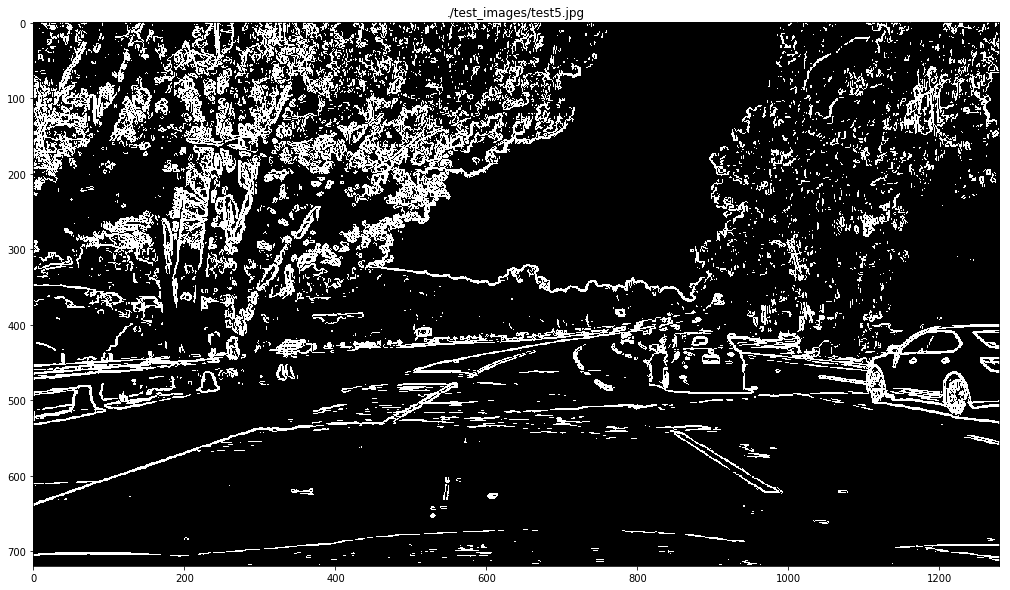

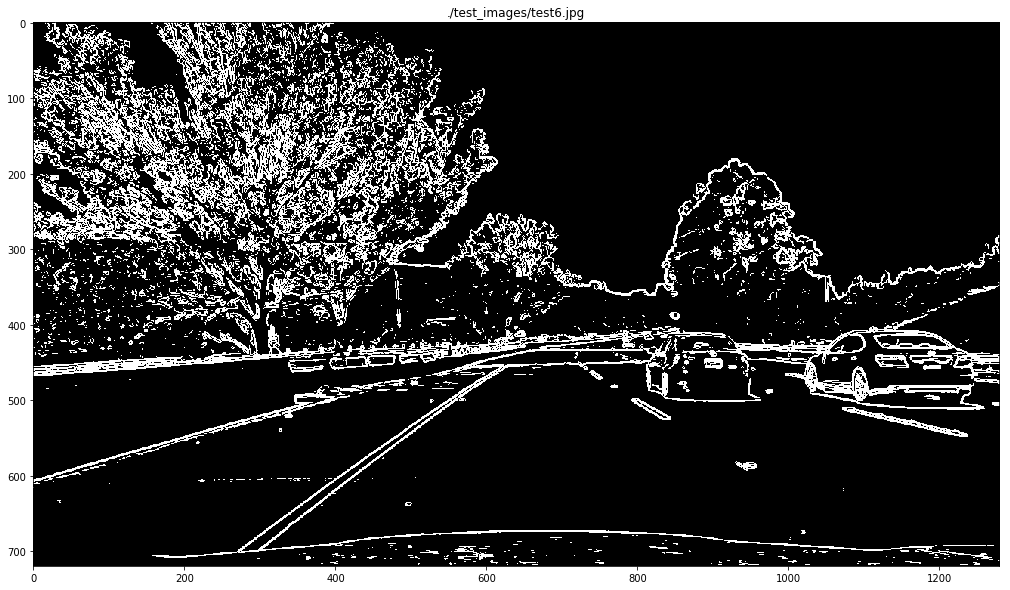

In [4]:
# Read all test images file
test_images = glob.glob('./test_images/*.jpg')

ksize = 3

for fname in test_images:
    # Read the image
    image = mpimg.imread(fname)
    
    # Undistort test image
    image = cv2.undistort(image, mtx, dist, None, mtx)
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 200))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 200))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(mag_b)
    combined_binary[(gradx == 1) | (grady == 1)] = 1

    # Display the binary output image
    f, ax1 = plt.subplots(1, 1, figsize=(20,10))
    ax1.set_title(fname)
    ax1.imshow(combined_binary, cmap='gray')

plt.show()

** Color Thresholding **

RGB color spaces is not good enough to capture different pixel in image that are differenced by light intensity. In the case of image taken from road, light intensity is the most parameter that differentiate the result. So I will use either HSL or HSV color space to extract lane line. 

Here's the algorithm / function for color channel thresholding:

In [5]:
# Calculate hls color channel
def hsl_threshold(img, color_channel = 's', thresh=(170, 255)):
    # Convert to HLS color space
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # Which channel?
    if color_channel == 'h':
        channel = hsl[:, :, 0]
    elif color_channel == 'l':
        channel = hsl[:, :, 1]
    elif color_channel == 's':
        channel = hsl[:, :, 2]
    
    # Threshold color channel
    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return binary

# Calculate hsv color channel
def hsv_threshold(img, color_channel = 's', thresh=(170, 255)):
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # Which channel?
    if color_channel == 'h':
        channel = hsv[:, :, 0]
    elif color_channel == 's':
        channel = hsv[:, :, 1]
    elif color_channel == 'v':
        channel = hsv[:, :, 2]
    
    # Threshold color channel
    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return binary

I used predefined function above with various test images. HSL with 'S' color channel able to retain lane lines with various condition (dark, shadow, different road color). While when using HSV, 'V' color channel is the one able to retain lane lines. Based on various sources found in internet, HSV is better to be used in computer vision. Below experiment showing how I use HSV color channel to define lane lines from test images.

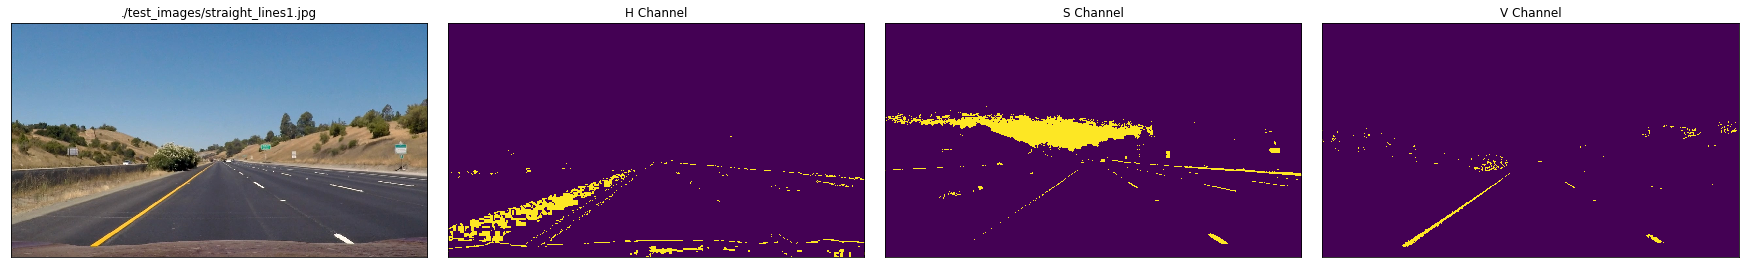

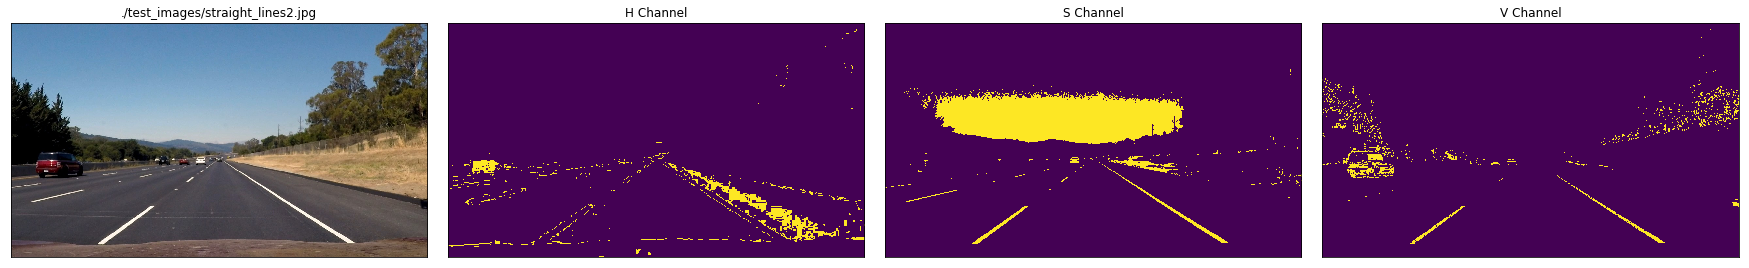

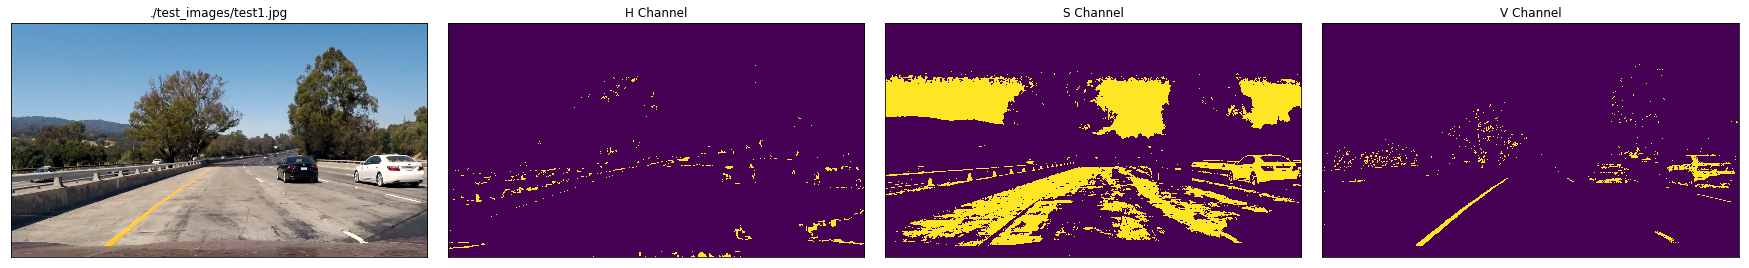

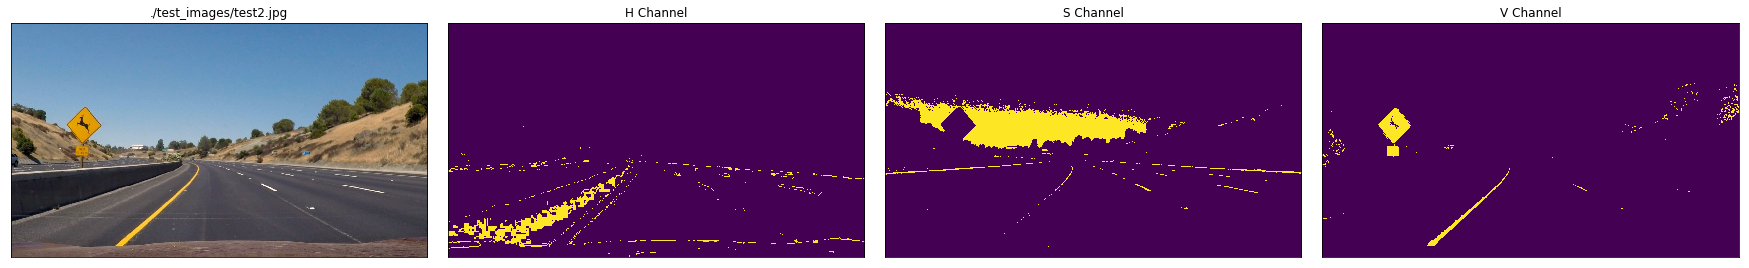

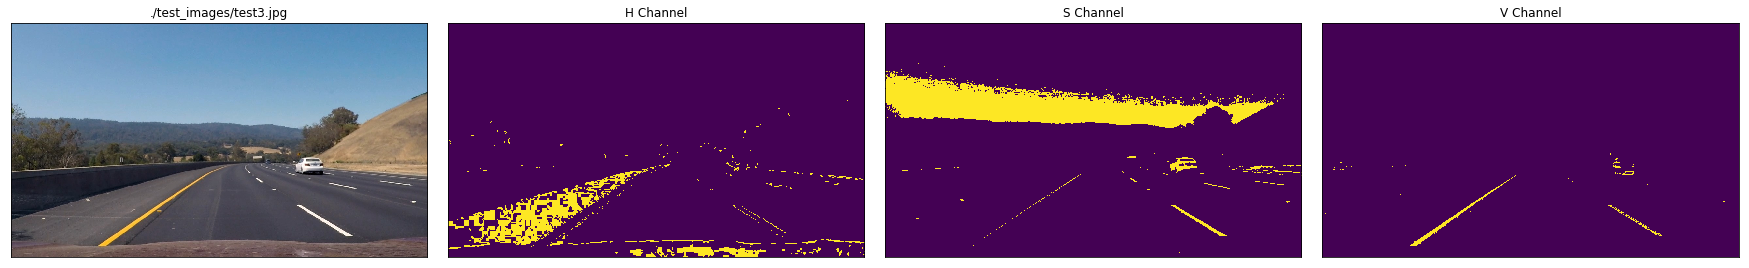

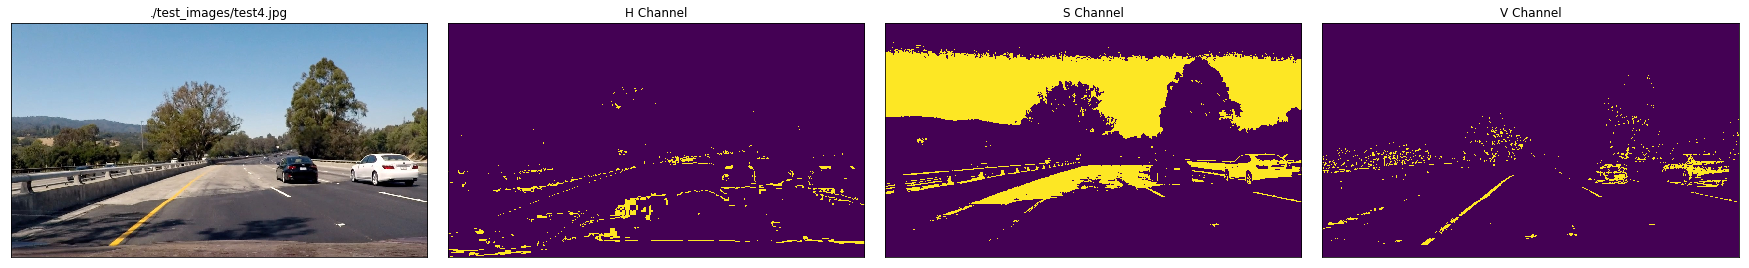

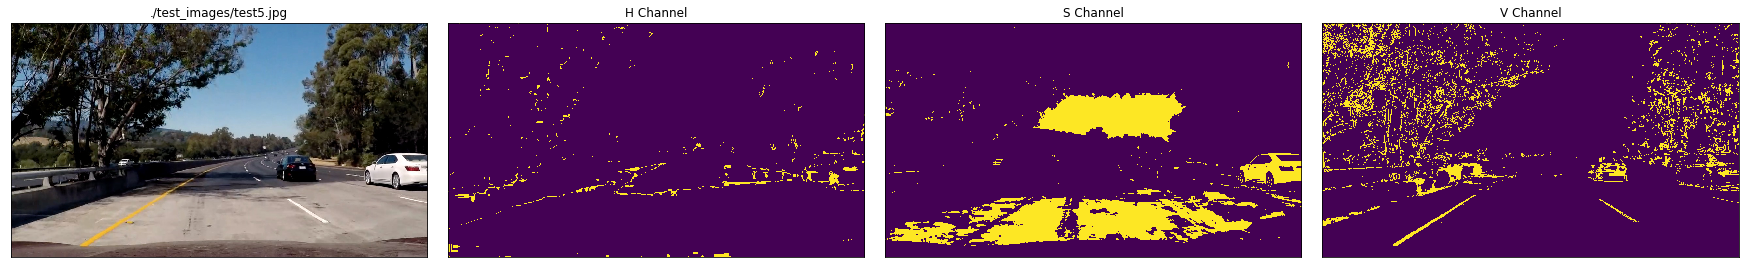

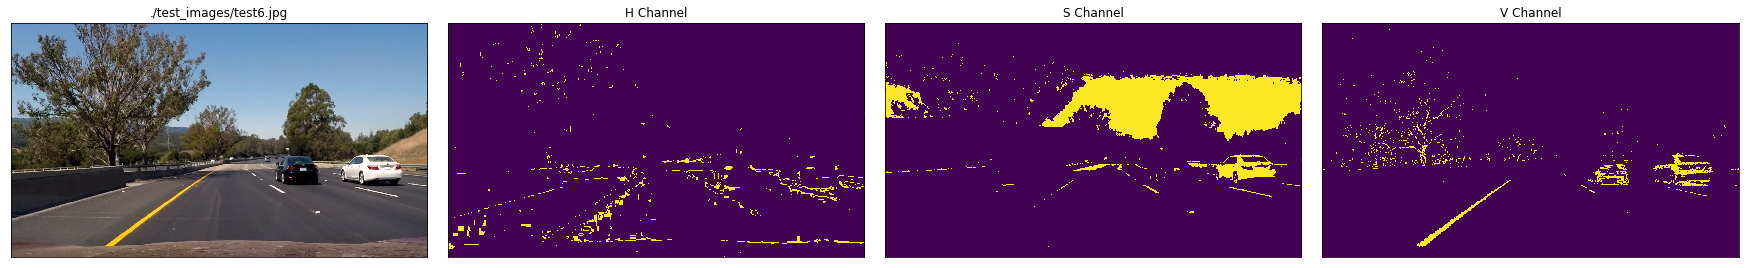

In [6]:
# Read all test images file
test_images = glob.glob('./test_images/*.jpg')

images_title = ["Source Image", "H Channel", "S Channel", "V Channel"]

# Perform color channeled on test images to see which channel best to use
for fname in test_images:
    # Read the image
    image = mpimg.imread(fname)
    
    # Retrieve color channeled image
    image_h = hsv_threshold(image, color_channel = 'h', thresh = (170, 255))
    image_s = hsv_threshold(image, color_channel = 's', thresh = (170, 255))
    image_v = hsv_threshold(image, color_channel = 'v', thresh = (170, 255))

    images = [image, image_h, image_s, image_v]
    
    # Plot the result
    fig = plt.figure(figsize = (24, 9))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    # Display result of color channeled image for each test images
    for i in range(4):
        axis = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
        if i == 0:
            axis.set_title(fname)
        else:
            axis.set_title(images_title[i])
        axis.imshow(images[i])
    
    plt.show()


As shown in the images above, 'V' channel successfully extracted yellow lane lines with any type of road color (light or dark). However, in many cases the white middle lane lines doesn't detected very well. So I need to combined between color threshold and also gradient threshold.

---

**Combined of Color and Gradient threshold**

Here's the combination of color and gradient threshold based on exercise above. I can see the resulting binary output able to extract the lane lines in all situation, not only the side-road yellow lane lines but also the middle-road white lane lines.

In [10]:
# Function to combine color and gradient threshold
def color_gradient(img):
    # Undistort image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Apply color and gradient threshold
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(30, 200))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(30, 200))
    image_v = hsv_threshold(img, color_channel = 'v', thresh = (170, 255))

    # Combine the two binary thresholds
    binary = np.zeros_like(mag_b)
    binary[(gradx == 1) | (grady == 1) | (image_v == 1)] = 1
    
    return binary

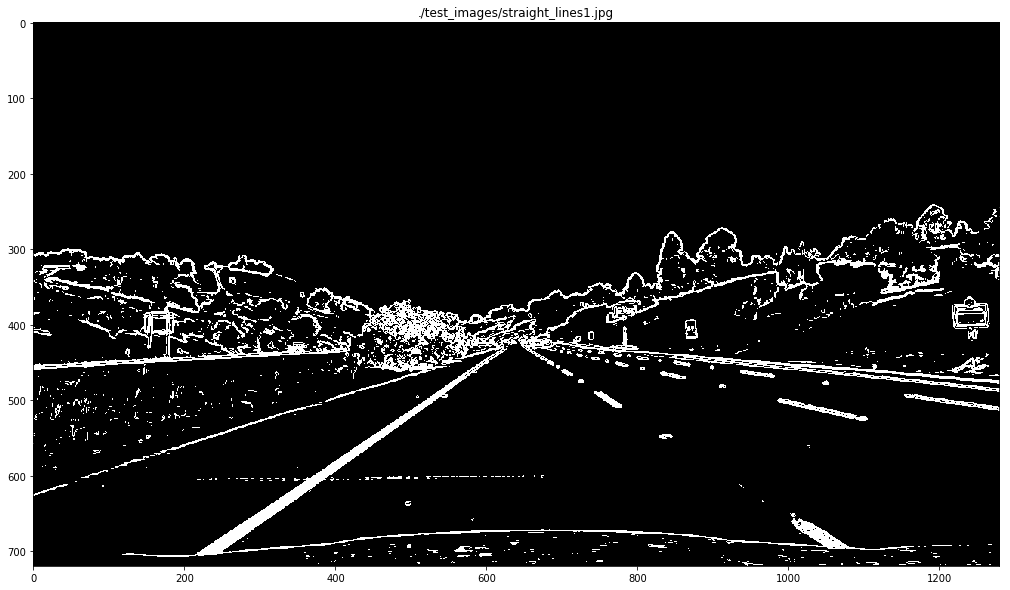

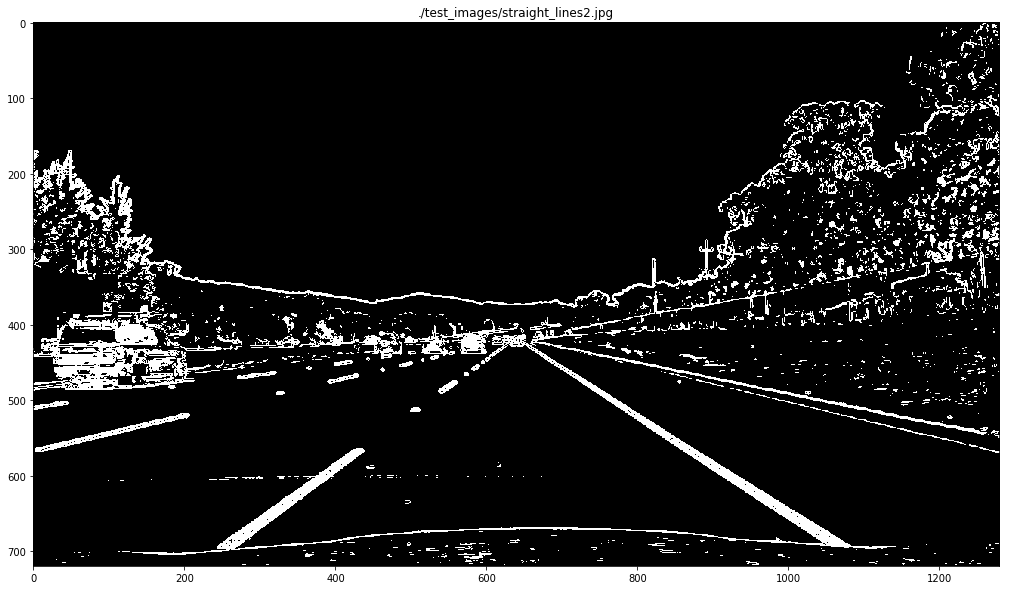

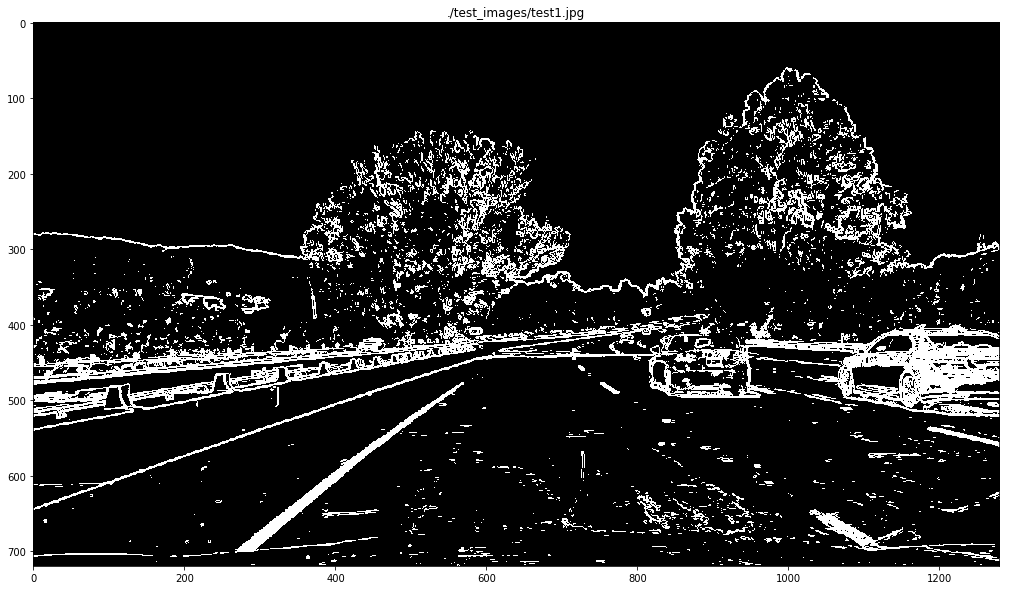

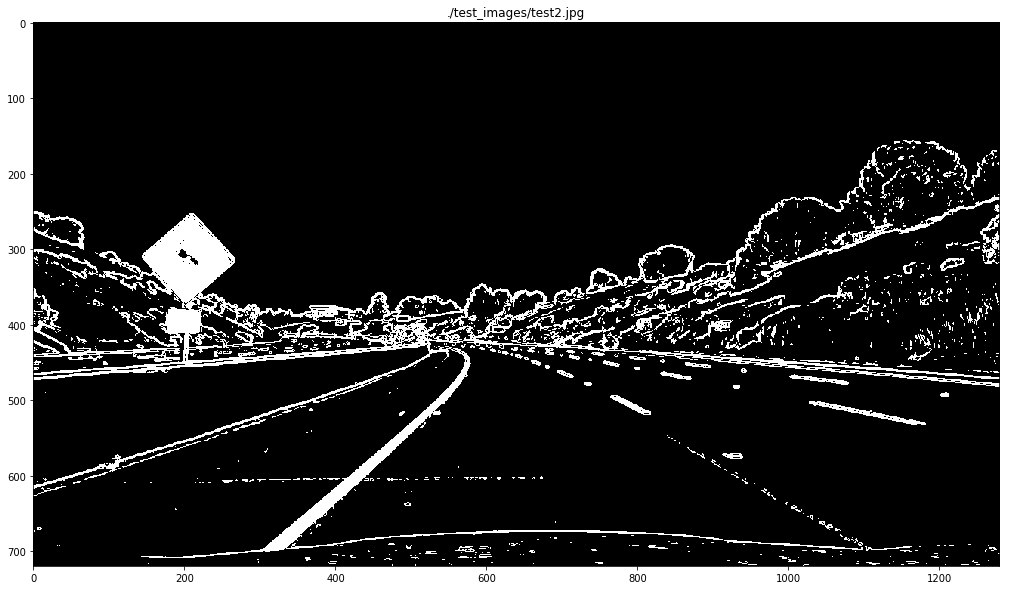

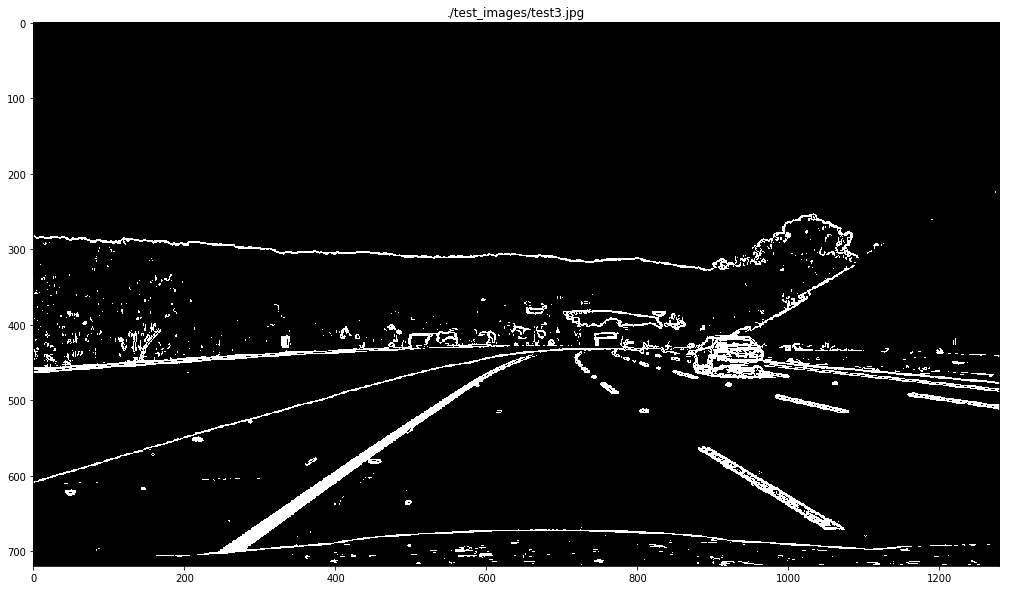

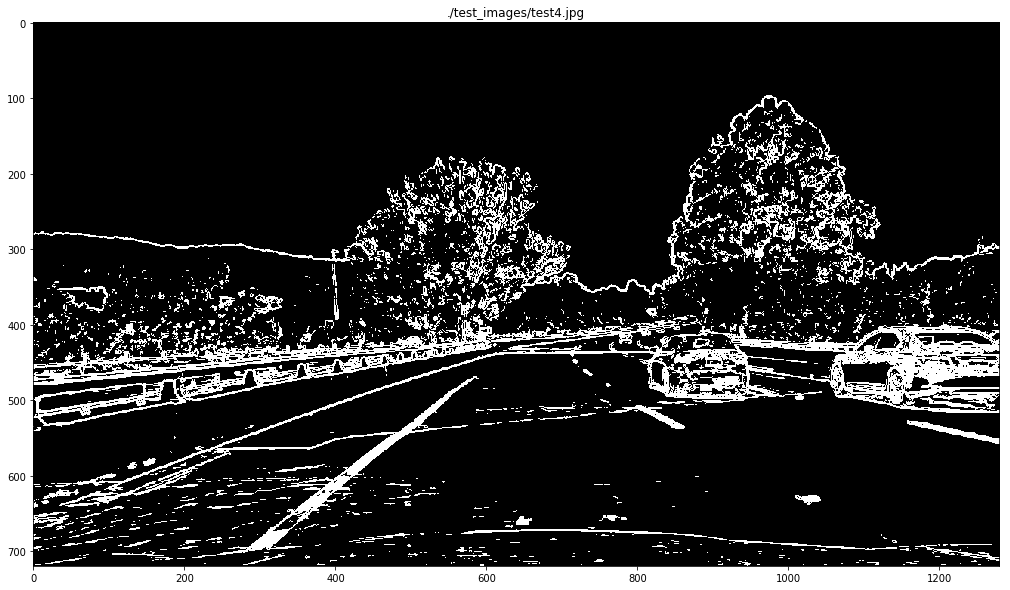

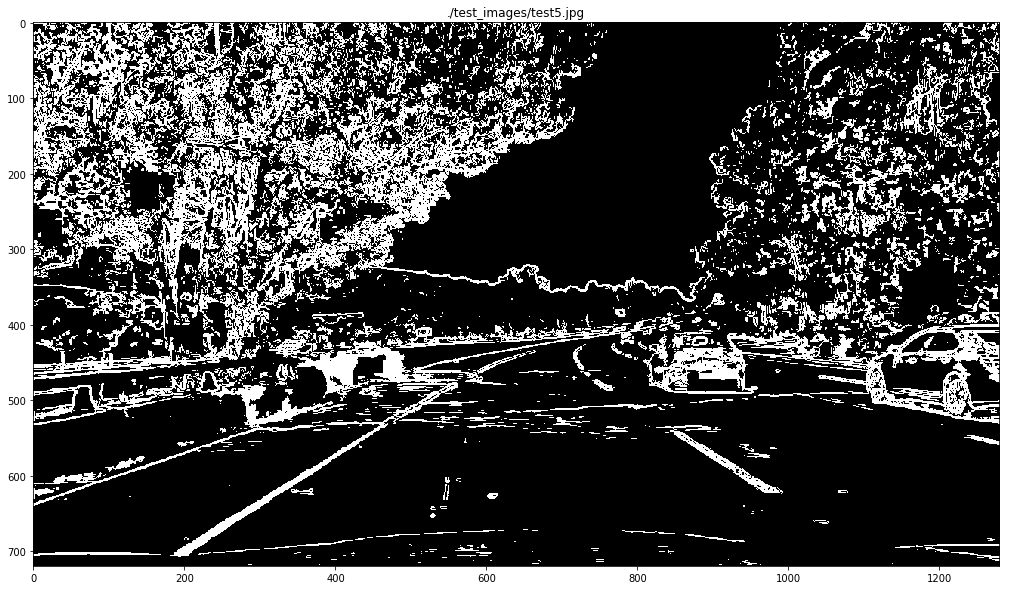

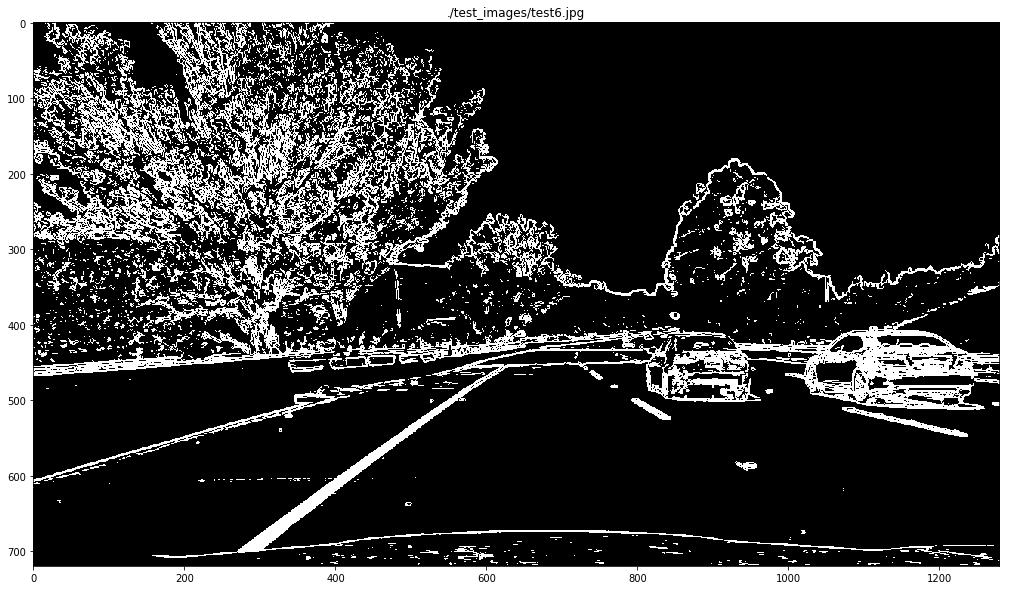

In [11]:
# Read all test images file
test_images = glob.glob('./test_images/*.jpg')

ksize = 3

for fname in test_images:
    # Read the image
    image = mpimg.imread(fname)
    
    combined_binary = color_gradient(image)

    # Display the binary output image
    f, ax1 = plt.subplots(1, 1, figsize=(20,10))
    ax1.set_title(fname)
    ax1.imshow(combined_binary, cmap='gray')

plt.show()

## Part 3: Perspective Transform

Perspective transform is used in order to get a bird's-eye view of an image. Transforming into bird's-eye view is required to get an exact parallel view between 2 lane lines. Initially due to perspective in the 2D image, lane lines (left and right) are getting narrow on the road ahead. Transforming to bird's-eye view will correct the distance between two lane line as they are in the real world. This will also make it easier later on to fit polynomials to the lane lines and measure the curvature.

In [31]:
# Perform perspective transform
def birds_eye(img, display=True, read = True):
    
    # Perform binary and gradient threshold
    binary = color_gradient(img)
     
    img_size = (img.shape[1], img.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(binary, M, img_size)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(warped, cmap='gray')
        ax2.set_title('Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped

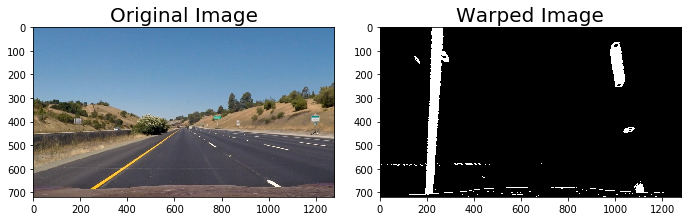

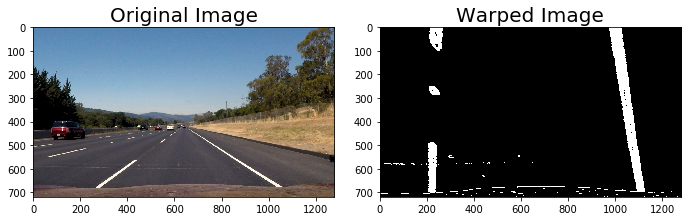

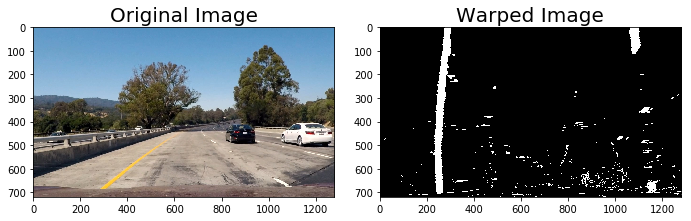

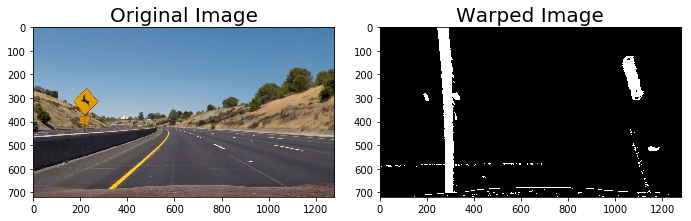

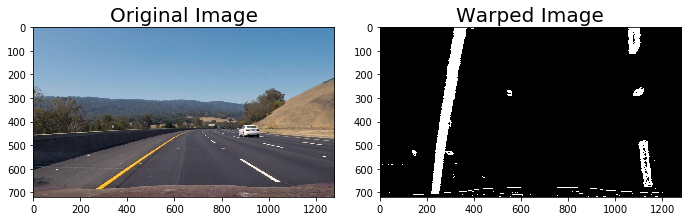

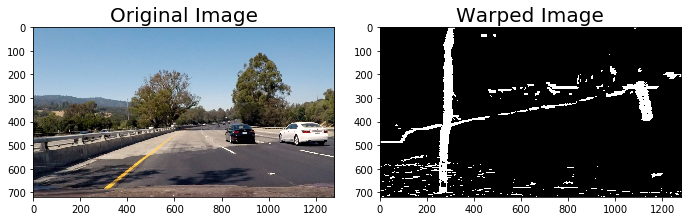

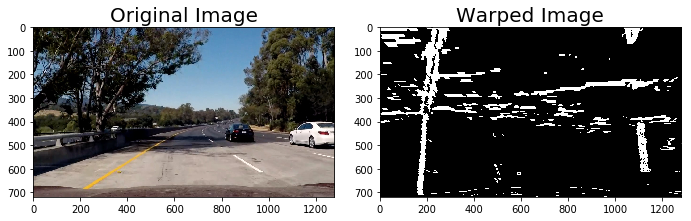

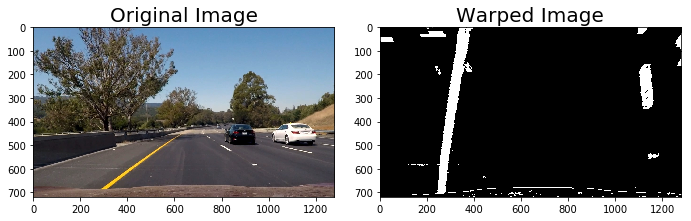

In [32]:
for fname in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(fname)
    birds_eye(image)

## Part 4: Polynomial

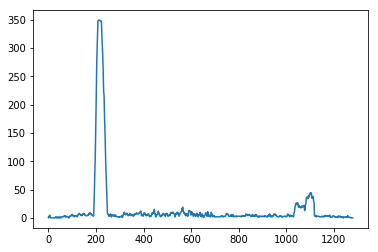

In [36]:
image = mpimg.imread('test_images/straight_lines1.jpg')

t_image = birds_eye(image, display=False)
binary_warped = t_image

histogram = np.sum(t_image[t_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)
    
    

In [39]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

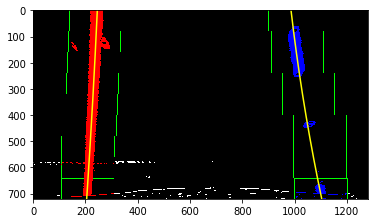

In [40]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [41]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

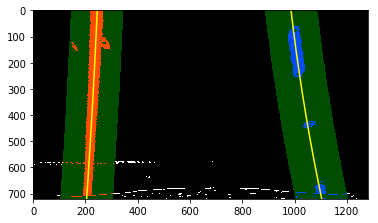

In [42]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [38]:
def fill_lane(image):
    
    combined_binary = birds_eye(image, display=False)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((birds_eye(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, lefty, color='green', linewidth=3)
    ax1.plot(right_fitx, righty, color='green', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
    if center < 640:
        ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    else:
        ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=10)
    ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=10)

In [24]:
for fname in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(fname)
    fill_lane(image)

SystemError: <built-in method nonzero of numpy.ndarray object at 0x11ce8f120> returned a result with an error set